## Grad-Shafranov free-boundary problem

In [3]:
from firedrake import *
from firedrake.pyplot import *
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp

In [4]:
# Just to compile the solver functions without errors
mesh = UnitSquareMesh(3,3)
V = FunctionSpace(mesh, "P", 1)

### Fixed-point iterations solver:

In the cell below, functions that define the bilinear form in the variational formulation of Grad-Sahfranov are defined. In particular:
1. Defines the varf of nonlinear general GS 
2. Defines the varf of GS for a fixed point iteration

In [5]:
# Defines the bilinear form for the variational problem:
def GS_varf(G, phi, psi):
    # Define the bilinear form:
    a  = (dot(grad(psi), grad(phi)) + (1/x) * Dx(psi, 0) * phi) * dx - (G(x,psi) * phi) * dx
    # L = 0
    return a

# Define the variational formulation for the fixed point iteration:
def GS_varf_Picard(G, phi, psi, psi_old, psi_mask, vessel_mask, coils_mask):
    # Define the bilinear form:
    a  = (dot(grad(psi), grad(phi)) + (1/x) * Dx(psi, 0) * phi) * dx \
        - psi_mask * G(x,psi_old) * phi * dx \
        - coils_mask * phi * dx \
        - vessel_mask * phi * dx
    # L = 0
    return a

In the cell below, a function that computes the plasma boundary with the computed $\psi$ and updates it for the following iteration.

In [6]:
def update_plasma_boundary(psi, limiter_points, psi_mask):
    # Find the maximum value of psi at the limiter points:
    psi_vals = []
    for (x_pt, y_pt) in limiter_points:
        try:
            psi_vals.append(psi.at((x_pt, y_pt)))
        except:
            raise ValueError(f"Point {(x_pt, y_pt)} outside domain!")
    psi0 = max(psi_vals)

    # Update the plasma boundary mask:
    #psi0_func = Function(V)
    #psi0_func.interpolate(Constant(psi0))
    #psi_mask.interpolate(conditional(psi > psi0_func, 1.0, 0.0))

    epsilon = 0.01
    psi_mask.interpolate(0.5 + 0.5 * tanh((psi - psi0) / (epsilon * psi0)))

    #fig, ax = plt.subplots()
    #plt.colorbar(tripcolor(psi_mask, axes=ax))
    #plt.title("Plasma Boundary")
    #plt.xlabel("x")
    #plt.ylabel("y")
    #plt.axis('equal')
    #plt.show()

    return psi0

def initialize_plasma_boundary(Vessel, j_cv):

    # ASSUME A CIRCULAR VACUUM CHAMBER:
    # Get the center and radius of the circle:
    x0 = Vessel[0]
    y0 = Vessel[1]
    r = Vessel[2]
    thickness = Vessel[3]

    # Define the initial plasma boundary as the whole vessel:
    psi_mask = Function(V)
    #psi_mask.interpolate(conditional((x - x0)**2 + (y - y0)**2 < r**2, 1.0, 0.0))
    #psi_mask.interpolate(0.5 + 0.5 * tanh(( (x - x0)**2 + (y - y0)**2 - r**2 ) / 0.01) )
    psi_mask.interpolate(0.5 + 0.5 * tanh(( r**2 - (x - x0)**2 - (y - y0)**2) / 0.01) )

    #fig, ax = plt.subplots()
    #plt.colorbar(tripcolor(psi_mask, axes=ax))
    #plt.title("Initial Vessel Mask")
    #plt.xlabel("x")
    #plt.ylabel("y")
    #plt.axis('equal')
    #plt.show()

    # Define the vacuum vessel wall mask:
    vessel_mask = Function(V)
    vessel_mask.interpolate(conditional((x - x0)**2 + (y - y0)**2 < (r + thickness)**2, 1.0, 0.0))
    vessel_mask.assign(Constant(j_cv) * (vessel_mask - psi_mask)) # Vessel mask = j_cv on the vacuum chamber walls

    return psi_mask, vessel_mask

In the cell below, the contribution of the coils current in the bilinear form is computed

In [9]:
def coils_contribution(I, coils):
    # Number of coils:
    n = len(I)

    # Check if the number of coils matches the number of currents:
    if n != len(coils):
        raise ValueError("Number of coils and currents do not match!")
    
    # Create the coils mask:
    coils_mask = Function(V)

    # Iterate over the coils:
    for i in range(n):

        [x_min, x_max, y_min, y_max] = coils[i]   # ASSUMPTION: COILS ARE SQUARES !

        # Compute coils size:
        S = (x_max - x_min) * (y_max - y_min)

        # Define the coils mask:
        coils_mask.interpolate(conditional(
            And( And(x_min <= x, x <= x_max), And(y_min <= y, y <= y_max) ),
            I[i] / S,
            0.0
        ))

    return coils_mask

In the cell below, function "GradShafranov" solves the free-boundary Grad-Shafranov problem by using fixed point method.

In [10]:
def GradShafranov(G, limiter_points, I_coils, pos_coils, Vessel, j_cv, initial_psi = None, show_plots = False):

  # Define trial and test functions:
  psi = Function(V)
  phi = TestFunction(V)

  # Initialize the plasma boundary as the whole domain:
  psi_mask, vessel_mask = initialize_plasma_boundary(Vessel, j_cv)

  # Initialize the flux function:
  psi_old = Function(V, name="Flux Old")
  if initial_psi is not None:
    psi_old.interpolate(initial_psi(x,y))
  else:
    psi_old.interpolate(Constant(0.0))

  # Define homogeneous Dirichlet boundary condition:
  bc = DirichletBC(V, 0.0, 'on_boundary')

  # Compute coils contribution:
  coils_mask = coils_contribution(I_coils, pos_coils)

  # Solve with Picard iterative method:
  maxit = 100000
  it = 0
  tol = 1e-5
  #tol_bdry = 1e-3
  err = tol+1

  X, Y = np.meshgrid(np.linspace(0, 1, n), np.linspace(0, 1, n))
  PSI = np.zeros_like(X)

  # Output file for saving the solution:
  outfile = VTKFile("flux.pvd")

  while it < maxit and err > tol: #and boundary_error > tol_bdry:
    # Define the variational problem:
    a = GS_varf_Picard(G, phi, psi, psi_old, psi_mask, vessel_mask, coils_mask)
    solve(a == 0, psi, bcs=[bc])

    # Compute the error:
    err = errornorm(psi, psi_old, 'H1') / norm(psi_old, 'H1')

    # Update the mask for plasma boundary:
    #psi0, boundary_error = update_plasma_boundary(psi, limiter_points, psi_mask)
    psi0 = update_plasma_boundary(psi, limiter_points, psi_mask)

    # Print the iteration values:
    #print("Iteration = ", it, " Error = ", err, " $\Omega_p$ at $\psi= ", psi0, " Boundary Error = ", boundary_error)
    print("Iteration = ", it, " Error = ", err, " psi at boundary = ", psi0)

    # Update the old flux function:
    psi_old.assign(psi)

    # Check number of iterations:
    it += 1
    if it > maxit: 
      print('Nonlinear solver di NOT converge!\nRelative error =', err, 'after', it, 'iterations.')

    # Save the current solution:
    outfile.write(psi)
    
    # Plot the solution at the current iteration:
    if(show_plots):
      for i in range(n):
        for j in range(n):
          point = (X[j, i], Y[j, i])  # Note: meshgrid ordering
          try:
            PSI[j, i] = psi.at(point)  # psi.at expects a tuple (x,y)
          except:
            PSI[j, i] = np.nan         # Mark outside points as nan

      fig, ax = plt.subplots()
      fig.colorbar(tripcolor(psi, axes=ax))
      plt.contour(X, Y, PSI, levels=[psi0], colors='red')
      plt.scatter(*zip(*limiter_points), color='blue', label='Limiter Points')
      plt.title(r"Solution $\psi$. In red the plasma boundary")
      plt.xlabel("x")
      plt.ylabel("y")
      plt.legend()
      plt.axis('equal')
      plt.show()

  return psi, psi0

### Solov'ev equilibrium - a simple example

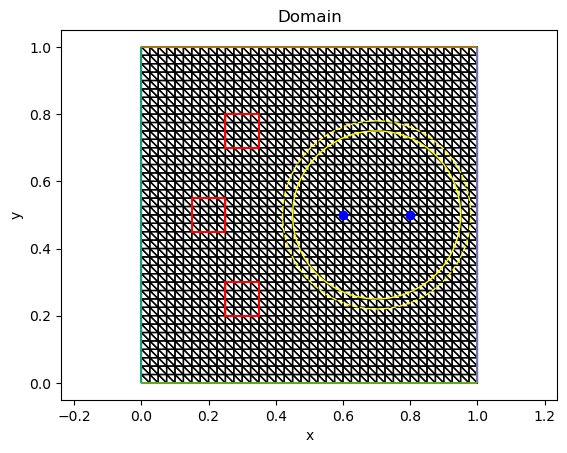

In [11]:
n = 40
mesh = UnitSquareMesh(n,n)
V = FunctionSpace(mesh, "P", 2)
x, y = SpatialCoordinate(mesh)

# Define the limiter points:
limiter_points = [(0.8, 0.5), (0.6,0.5)]

# Define the coils:
pos_coils = [
    (0.15, 0.25, 0.45, 0.55), # Coil 1
    (0.25, 0.35, 0.7, 0.8),  # Coil 2
    (0.25, 0.35, 0.2, 0.3), # Coil 3
]

# Define the vacuum vessel:
Vessel = (0.7, 0.5, 0.25, 0.03) # (x0, y0, r, thickness)

# Display mesh:
fig, ax = plt.subplots()
triplot(mesh, axes=ax)
plt.scatter(*zip(*limiter_points), color='blue', label='Limiter Points')

# Plot the coils:
for coil in pos_coils:
    x_min, x_max, y_min, y_max = coil
    plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], color='red', label='Coil Edges')

# Plot the circular vessel:
inner_wall = plt.Circle((Vessel[0], Vessel[1]), Vessel[2], color='yellow', fill=False, label='Vessel')
outer_wall = plt.Circle((Vessel[0], Vessel[1]), Vessel[2] + Vessel[3], color='yellow', fill=False, linestyle='dashed')
ax.add_artist(inner_wall)
ax.add_artist(outer_wall)
plt.title(r"Domain")
plt.xlabel("x")
plt.ylabel("y")
plt.axis('equal')
plt.show()

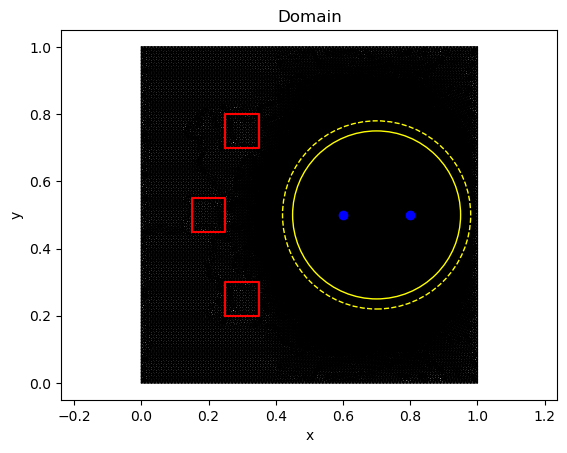

In [12]:
# Import mesh
mesh = Mesh("../Meshes/tokamak/tokamak_mesh.msh")
V = FunctionSpace(mesh, "P", 2)
x, y = SpatialCoordinate(mesh)

# Define the limiter points:
limiter_points = [(0.8, 0.5), (0.6,0.5)]

fig, ax = plt.subplots()
triplot(mesh, axes=ax)
plt.scatter(*zip(*limiter_points), color='blue', label='Limiter Points')

#cell_tags = mesh.cell_set
#print("Available cell tags:", cell_tags.)

# Define the coils:
pos_coils = [
    (0.15, 0.25, 0.45, 0.55), # Coil 1
    (0.25, 0.35, 0.7, 0.8),  # Coil 2
    (0.25, 0.35, 0.2, 0.3), # Coil 3
]

# Define the vacuum vessel:
Vessel = (0.7, 0.5, 0.25, 0.03) # (x0, y0, r, thickness)
for coil in pos_coils:
    x_min, x_max, y_min, y_max = coil
    plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], color='red', label='Coil Edges')

inner_wall = plt.Circle((Vessel[0], Vessel[1]), Vessel[2], color='yellow', fill=False, label='Vessel')
outer_wall = plt.Circle((Vessel[0], Vessel[1]), Vessel[2] + Vessel[3], color='yellow', fill=False, linestyle='dashed')
ax.add_artist(inner_wall)
ax.add_artist(outer_wall)
plt.title(r"Domain")
plt.xlabel("x")
plt.ylabel("y")
plt.axis('equal')
plt.show()


In [13]:
# Define G function:
def G(x, psi):
    return x**2 + psi

# Define initial guess for the flux function:
def initial_guess(x, y):
    #return 0.5 * x * (1 - x) * y * (1 - y)
    return 0.0

# Define the currents in coils:
I_coils = [0.01, 0.01, 0.0]

# Define the current density in the vacuum vessel:
j_cv = 0.01

# Compute solution using Grad-Shafranov solver:
psi, psi0 = GradShafranov(G, limiter_points, I_coils, pos_coils, Vessel, j_cv, initial_guess, show_plots=False)

/tmp/ipykernel_63948/3571098457.py:42: RuntimeWarning: divide by zero encountered in scalar divide
  err = errornorm(psi, psi_old, 'H1') / norm(psi_old, 'H1')


Iteration =  0  Error =  inf  psi at boundary =  0.015147279896850507
Iteration =  1  Error =  0.9015904105134993  psi at boundary =  0.0022519148455241627
Iteration =  2  Error =  0.1839455937502505  psi at boundary =  0.0018942538369940204
Iteration =  3  Error =  0.11958069515160122  psi at boundary =  0.001704976896256637
Iteration =  4  Error =  0.09481516612402566  psi at boundary =  0.0015721219029231047
Iteration =  5  Error =  0.08086196296475623  psi at boundary =  0.001468928949361523
Iteration =  6  Error =  0.07160298023690757  psi at boundary =  0.0013841929978313807
Iteration =  7  Error =  0.06509312313934387  psi at boundary =  0.0013124153851527124
Iteration =  8  Error =  0.060195988952011455  psi at boundary =  0.0012496296956886787
Iteration =  9  Error =  0.058415040242777216  psi at boundary =  0.0011915475471802927
Iteration =  10  Error =  0.055902008636771534  psi at boundary =  0.0011383396650463387
Iteration =  11  Error =  0.05241012582851645  psi at bounda

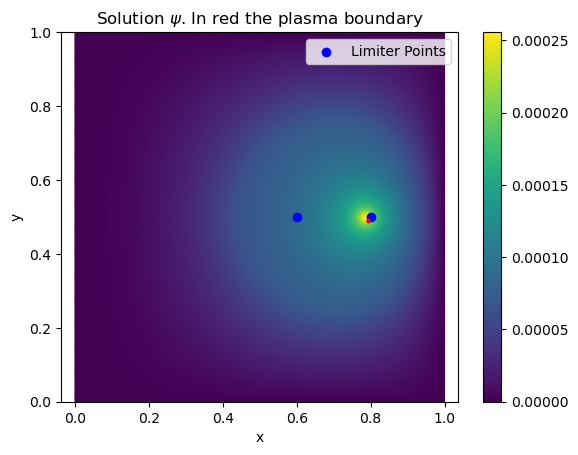

In [14]:
# Plot the solution:
X, Y = np.meshgrid(np.linspace(0, 1, n), np.linspace(0, 1, n))
PSI = np.zeros_like(X)
for i in range(n):
    for j in range(n):
        point = (X[j, i], Y[j, i])  # Note: meshgrid ordering
        try:
            PSI[j, i] = psi.at(point)  # psi.at expects a tuple (x,y)
        except:
            PSI[j, i] = np.nan         # Mark outside points as nan

fig, ax = plt.subplots()
fig.colorbar(tripcolor(psi, axes=ax))
plt.contour(X, Y, PSI, levels=[psi0], colors='red')
plt.scatter(*zip(*limiter_points), color='blue', label='Limiter Points')
plt.title(r"Solution $\psi$. In red the plasma boundary")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.axis('equal')
plt.show()

In [15]:
max_psi = psi.dat.data.max()
print(f"Maximum value of psi: {max_psi:.4f} at the plasma boundary.")

Maximum value of psi: 0.0003 at the plasma boundary.
